In [23]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [24]:
# Load Dataset
file_path = "data/group5.xlsx"  # Use the relative path if the file is in the same directory
df = pd.read_excel(file_path)

In [25]:
# Inspect the Data
print(df.head())
print(df.info())
print(df.describe())

       id  Gender  Age       City Profession  Academic_Pressure  \
0  116782    Male   23     Bhopal    Student                  5   
1   28324    Male   33       Pune    Student                  3   
2   97624  Female   19     Nashik    Student                  4   
3  122053    Male   25    Chennai    Student                  3   
4   67402    Male   32  Bangalore    Student                  5   

   Work_Pressure  CGPA  Study_Satisfaction  Job_Satisfaction  \
0              0  8.74                   2                 0   
1              0  7.88                   4                 0   
2              0  5.45                   1                 0   
3              0  7.74                   1                 0   
4              0  9.96                   1                 0   

      Sleep_Duration Dietary_Habits    Degree  \
0          7-8 hours      Unhealthy      B.Ed   
1          5-6 hours       Moderate       PhD   
2  More than 8 hours      Unhealthy  Class 12   
3  More than 8 h

In [26]:
# Drop ID column since it’s not useful for prediction
df.drop(columns=['id'], inplace=True)

In [27]:
# Handle Missing Values (Fill numerical columns with median, categorical with mode)
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].fillna(df[column].mode()[0])
    else:
        df[column] = df[column].fillna(df[column].median())

In [33]:
# Define Features (X) and Target (y)
X = df.drop(columns=['Depression'])  # Features
y = df['Depression']  # Target Variable

# Define variable types
numerical_columns = ['Age', 'CGPA', 'Work_Study_Hours']
ordinal_columns = ['Academic_Pressure', 'Work_Pressure', 'Study_Satisfaction', 'Job_Satisfaction', 
                  'Sleep_Duration', 'Financial_Stress']
nominal_columns = ['Gender', 'City', 'Profession', 'Dietary_Habits', 'Degree', 
                   'Have_you_ever_had_suicidal_thoughts_', 'Family_History_of_Mental_Illness']

# Step 1: Label Encode Ordinal Categorical Variables
# Define the order for Sleep_Duration
sleep_duration_order = ['Less than 5 hours', '5-6 hours', '6-7 hours', '7-8 hours', 'More than 8 hours']
label_encoders = {}
for col in ordinal_columns:
    if col == 'Sleep_Duration':
        # Map Sleep_Duration categories to ordered integers
        sleep_duration_mapping = {category: idx for idx, category in enumerate(sleep_duration_order)}
        X[col] = X[col].map(sleep_duration_mapping)
        label_encoders[col] = sleep_duration_mapping  # Store the mapping instead of a LabelEncoder
    else:
        # For other ordinal variables, ensure LabelEncoder is trained on the full range 0–5
        X[col] = X[col].astype(int)
        # Create a LabelEncoder and train it on the full range [0, 1, 2, 3, 4, 5]
        label_encoders[col] = LabelEncoder()
        full_range = np.array([0, 1, 2, 3, 4, 5])  # Full range of possible values
        label_encoders[col].fit(full_range)
        # Transform the actual data
        X[col] = label_encoders[col].transform(X[col])

# Step 2: Normalize Numerical Features
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Step 3: One-Hot Encode Nominal Categorical Variables
X = pd.get_dummies(X, columns=nominal_columns, drop_first=True)

# Print the final feature set shape to verify
print("Final Feature Set Shape:", X.shape)

Final Feature Set Shape: (19999, 93)


In [34]:
# Split Data into Training & Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
# Train a Random Forest Model (Handles Class Imbalance if Needed)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Accuracy: 0.83475

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.79      1666
           1       0.84      0.88      0.86      2334

    accuracy                           0.83      4000
   macro avg       0.83      0.82      0.83      4000
weighted avg       0.83      0.83      0.83      4000


Confusion Matrix:
 [[1277  389]
 [ 272 2062]]


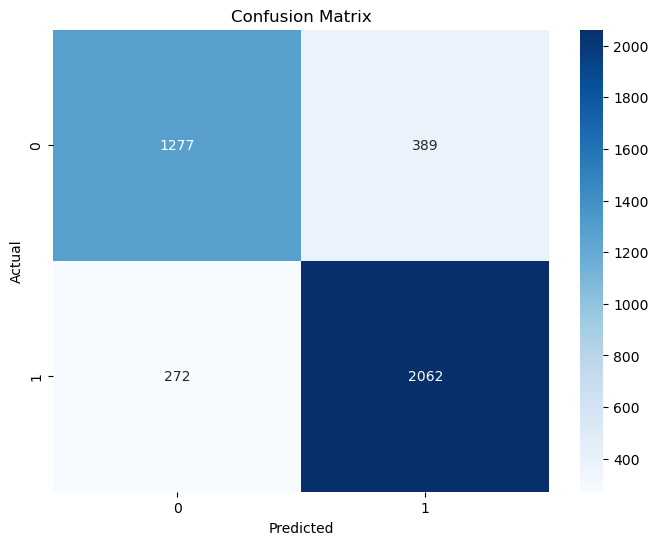

In [36]:
# Predict on Test Set
y_pred = rf_model.predict(X_test)

# Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [37]:
# Save the scaler, model, categorical options, feature names, and label encoders
joblib.dump(scaler, 'model/scaler.joblib')
joblib.dump(rf_model, 'model/random_forest_model.joblib')
categorical_options = {col: df[col].unique().tolist() for col in nominal_columns}
joblib.dump(categorical_options, 'model/categorical_options.joblib')
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'model/feature_names.joblib')
joblib.dump(label_encoders, 'model/label_encoders.joblib')

print("Model and related files saved successfully.")

Model and related files saved successfully.
